In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from utils.acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model

from utils.acdc_dataset import *
from utils.training import *
from utils.vqVAE_MRI import *
from utils.vqVAE import *



## Preparing Dataset 

In [2]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [3]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")



#### Segmentation Dataset

In [4]:
# train_dataset = load_dataset(train_set_path)
# test_dataset  = load_dataset(test_set_path)


# input_transforms = Compose([
#     transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
#     One_hot_Transform(num_classes=4)
#     ])


# TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
# TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

# TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
# TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)



#### MRI Dataset

In [5]:

train_dataset = load_dataset(train_set_path, modality='MRI')
test_dataset  = load_dataset(test_set_path, modality='MRI')


In [6]:
# class MinMaxNormalize:
#     def __init__(self, min_value=0.0, max_value=1.0):
#         self.min_value = min_value
#         self.max_value = max_value

#     def __call__(self, image):
#         min_img = image.min()
#         max_img = image.max()

#         # Apply Min-Max scaling to normalize the image
#         normalized_image = (image - min_img) / (max_img - min_img)  # Scales to [0, 1]
#         scaled_image = normalized_image * (self.max_value - self.min_value) + self.min_value  # Scale to [min_value, max_value]

#         return scaled_image

# class PercentileClip:
#     def __init__(self, lower_percentile=1, upper_percentile=99):
#         self.lower_percentile = lower_percentile
#         self.upper_percentile = upper_percentile

#     def __call__(self, image):
#         # Flatten the image to compute percentiles
#         flattened_image = image.view(-1)
        
#         # Compute the percentile values
#         lower_bound = torch.quantile(flattened_image, self.lower_percentile / 100.0)
#         upper_bound = torch.quantile(flattened_image, self.upper_percentile / 100.0)
        
#         # Clip the image values to the computed bounds
#         clipped_image = torch.clamp(image, min=lower_bound.item(), max=upper_bound.item())
        
#         return clipped_image

In [7]:
class PercentileClip:
    def __init__(self, lower_percentile=1, upper_percentile=99):
        self.lower_percentile = lower_percentile
        self.upper_percentile = upper_percentile

    def __call__(self, image):
        # Flatten the image to compute percentiles
        flattened_image = image.reshape(-1)
        
        # Compute the percentile values
        lower_bound = torch.quantile(flattened_image, self.lower_percentile / 100.0)
        upper_bound = torch.quantile(flattened_image, self.upper_percentile / 100.0)
        
        # Clip the image values to the computed bounds
        clipped_image = torch.clamp(image, min=lower_bound.item(), max=upper_bound.item())
        
        return clipped_image

In [8]:

input_transforms_MRI = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    PercentileClip(lower_percentile=1, upper_percentile=99),
    MinMaxNormalize(min_value=0.0, max_value=1.0),

    ])

TrainDataset_MRI = ACDC_Dataset(data = train_dataset, transforms= input_transforms_MRI) 
TestDataset_MRI  = ACDC_Dataset(data = test_dataset, transforms= input_transforms_MRI)

TrainLoader_MRI  = DataLoader(TrainDataset_MRI, batch_size = BATCH_SIZE, shuffle = True)
TestLoader_MRI   = DataLoader(TestDataset_MRI , batch_size = BATCH_SIZE, shuffle = True)

## Prepairing the model

In [9]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 1 
downsampling_factor = 8

In [10]:
# ACDC_VQVAE = VQVAE(in_channels, D, K, downsampling_factor)
ACDC_VQVAE_MRI = VQVAE_MRI(in_channels, D, K, downsampling_factor)


## Training the Model

In [11]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [12]:
### Learning parameters

model = ACDC_VQVAE_MRI.to(device)

lr = 5e-4
epochs = 100
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models_MRI/vqvae_mri_100_bestmodel.pth'

In [13]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader_MRI)).to(device)

In [14]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader_MRI), unit="batch", total=len(TrainLoader_MRI)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader_MRI.dataset)
    codebook_loss_epoch/= len(TrainLoader_MRI.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader_MRI, F.mse_loss, device)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, codebook_loss_values)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader_MRI)))

print("Training complete.")

100%|██████████| 119/119 [00:08<00:00, 14.20batch/s, loss=0.104] 


Epoch 0: Train Loss: 7.3173


100%|██████████| 119/119 [00:08<00:00, 14.80batch/s, loss=1.86] 


Epoch 1: Train Loss: 2.2445


100%|██████████| 119/119 [00:08<00:00, 14.85batch/s, loss=0.0561]


Epoch 2: Train Loss: 0.9672


100%|██████████| 119/119 [00:07<00:00, 14.93batch/s, loss=0.433]


Epoch 3: Train Loss: 0.1569


100%|██████████| 119/119 [00:07<00:00, 14.96batch/s, loss=0.081] 


Epoch 4: Train Loss: 0.1531


100%|██████████| 119/119 [00:07<00:00, 14.91batch/s, loss=0.0429]


Epoch 5: Train Loss: 0.0554


100%|██████████| 119/119 [00:07<00:00, 15.07batch/s, loss=0.0214]


Epoch 6: Train Loss: 0.0297


100%|██████████| 119/119 [00:07<00:00, 15.02batch/s, loss=0.0226]


Epoch 7: Train Loss: 0.0214


100%|██████████| 119/119 [00:07<00:00, 14.91batch/s, loss=0.0186]


Epoch 8: Train Loss: 0.0198


100%|██████████| 119/119 [00:08<00:00, 14.83batch/s, loss=0.0182]


Epoch 9: Train Loss: 0.0172


100%|██████████| 119/119 [00:07<00:00, 15.01batch/s, loss=0.0151]


Epoch 10: Train Loss: 0.0153


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.0133]


Epoch 11: Train Loss: 0.0140


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.0126]


Epoch 12: Train Loss: 0.0129


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.012] 


Epoch 13: Train Loss: 0.0120


100%|██████████| 119/119 [00:07<00:00, 14.96batch/s, loss=0.0105]


Epoch 14: Train Loss: 0.0114


100%|██████████| 119/119 [00:07<00:00, 15.03batch/s, loss=0.0107] 


Epoch 15: Train Loss: 0.0111


100%|██████████| 119/119 [00:07<00:00, 15.03batch/s, loss=0.0104] 


Epoch 16: Train Loss: 0.0106


100%|██████████| 119/119 [00:07<00:00, 14.92batch/s, loss=0.0103] 


Epoch 17: Train Loss: 0.0102


100%|██████████| 119/119 [00:07<00:00, 15.06batch/s, loss=0.0107] 


Epoch 18: Train Loss: 0.0100


100%|██████████| 119/119 [00:08<00:00, 14.81batch/s, loss=0.00995]


Epoch 19: Train Loss: 0.0098


100%|██████████| 119/119 [00:07<00:00, 15.02batch/s, loss=0.00898]


Epoch 20: Train Loss: 0.0097


100%|██████████| 119/119 [00:08<00:00, 14.80batch/s, loss=0.0098] 


Epoch 21: Train Loss: 0.0095


100%|██████████| 119/119 [00:07<00:00, 14.95batch/s, loss=0.00848]


Epoch 22: Train Loss: 0.0094


100%|██████████| 119/119 [00:07<00:00, 14.89batch/s, loss=0.00837]


Epoch 23: Train Loss: 0.0092


100%|██████████| 119/119 [00:08<00:00, 14.79batch/s, loss=0.0101] 


Epoch 24: Train Loss: 0.0092


100%|██████████| 119/119 [00:08<00:00, 14.81batch/s, loss=0.00898]


Epoch 25: Train Loss: 0.0091


100%|██████████| 119/119 [00:08<00:00, 14.87batch/s, loss=0.00995]


Epoch 26: Train Loss: 0.0090


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00946]


Epoch 27: Train Loss: 0.0089


100%|██████████| 119/119 [00:07<00:00, 14.90batch/s, loss=0.00831]


Epoch 28: Train Loss: 0.0088


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.00774]


Epoch 29: Train Loss: 0.0087


100%|██████████| 119/119 [00:07<00:00, 14.96batch/s, loss=0.00863]


Epoch 30: Train Loss: 0.0089


100%|██████████| 119/119 [00:07<00:00, 14.93batch/s, loss=0.00881]


Epoch 31: Train Loss: 0.0085


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00828]


Epoch 32: Train Loss: 0.0085


100%|██████████| 119/119 [00:07<00:00, 14.92batch/s, loss=0.00843]


Epoch 33: Train Loss: 0.0084


100%|██████████| 119/119 [00:07<00:00, 14.95batch/s, loss=0.00858]


Epoch 34: Train Loss: 0.0083


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.0097] 


Epoch 35: Train Loss: 0.0083


100%|██████████| 119/119 [00:07<00:00, 14.95batch/s, loss=0.00809]


Epoch 36: Train Loss: 0.0083


100%|██████████| 119/119 [00:07<00:00, 15.02batch/s, loss=0.00784]


Epoch 37: Train Loss: 0.0082


100%|██████████| 119/119 [00:07<00:00, 14.99batch/s, loss=0.00981]


Epoch 38: Train Loss: 0.0082


100%|██████████| 119/119 [00:08<00:00, 14.86batch/s, loss=0.00796]


Epoch 39: Train Loss: 0.0081


100%|██████████| 119/119 [00:07<00:00, 14.99batch/s, loss=0.00861]


Epoch 40: Train Loss: 0.0080


100%|██████████| 119/119 [00:07<00:00, 14.99batch/s, loss=0.00792]


Epoch 41: Train Loss: 0.0080


100%|██████████| 119/119 [00:07<00:00, 14.96batch/s, loss=0.0083] 


Epoch 42: Train Loss: 0.0079


100%|██████████| 119/119 [00:07<00:00, 14.93batch/s, loss=0.00857]


Epoch 43: Train Loss: 0.0079


100%|██████████| 119/119 [00:07<00:00, 14.95batch/s, loss=0.00663]


Epoch 44: Train Loss: 0.0079


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.00833]


Epoch 45: Train Loss: 0.0078


100%|██████████| 119/119 [00:07<00:00, 14.96batch/s, loss=0.00794]


Epoch 46: Train Loss: 0.0079


100%|██████████| 119/119 [00:07<00:00, 14.97batch/s, loss=0.00824]


Epoch 47: Train Loss: 0.0078


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00802]


Epoch 48: Train Loss: 0.0077


100%|██████████| 119/119 [00:07<00:00, 14.92batch/s, loss=0.00811]


Epoch 49: Train Loss: 0.0077


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00857]


Epoch 50: Train Loss: 0.0077


100%|██████████| 119/119 [00:07<00:00, 14.92batch/s, loss=0.00803]


Epoch 51: Train Loss: 0.0077


100%|██████████| 119/119 [00:07<00:00, 15.01batch/s, loss=0.00702]


Epoch 52: Train Loss: 0.0076


100%|██████████| 119/119 [00:07<00:00, 14.97batch/s, loss=0.00745]


Epoch 53: Train Loss: 0.0076


100%|██████████| 119/119 [00:07<00:00, 14.88batch/s, loss=0.0081] 


Epoch 54: Train Loss: 0.0076


100%|██████████| 119/119 [00:07<00:00, 14.92batch/s, loss=0.00781]


Epoch 55: Train Loss: 0.0075


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.00734]


Epoch 56: Train Loss: 0.0076


100%|██████████| 119/119 [00:08<00:00, 14.85batch/s, loss=0.00695]


Epoch 57: Train Loss: 0.0075


100%|██████████| 119/119 [00:07<00:00, 14.91batch/s, loss=0.00666]


Epoch 58: Train Loss: 0.0075


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00736]


Epoch 59: Train Loss: 0.0075


100%|██████████| 119/119 [00:07<00:00, 14.95batch/s, loss=0.00727]


Epoch 60: Train Loss: 0.0075


100%|██████████| 119/119 [00:08<00:00, 14.85batch/s, loss=0.00782]


Epoch 61: Train Loss: 0.0075


100%|██████████| 119/119 [00:08<00:00, 14.83batch/s, loss=0.00715]


Epoch 62: Train Loss: 0.0074


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.00758]


Epoch 63: Train Loss: 0.0074


100%|██████████| 119/119 [00:07<00:00, 14.98batch/s, loss=0.00644]


Epoch 64: Train Loss: 0.0074


100%|██████████| 119/119 [00:07<00:00, 14.90batch/s, loss=0.00676]


Epoch 65: Train Loss: 0.0073


100%|██████████| 119/119 [00:08<00:00, 14.87batch/s, loss=0.00774]


Epoch 66: Train Loss: 0.0074


100%|██████████| 119/119 [00:07<00:00, 15.01batch/s, loss=0.00725]


Epoch 67: Train Loss: 0.0073


100%|██████████| 119/119 [00:07<00:00, 15.01batch/s, loss=0.00797]


Epoch 68: Train Loss: 0.0073


100%|██████████| 119/119 [00:08<00:00, 14.86batch/s, loss=0.00696]


Epoch 69: Train Loss: 0.0073


100%|██████████| 119/119 [00:08<00:00, 14.85batch/s, loss=0.00648]


Epoch 70: Train Loss: 0.0072


100%|██████████| 119/119 [00:08<00:00, 14.76batch/s, loss=0.00802]


Epoch 71: Train Loss: 0.0072


100%|██████████| 119/119 [00:07<00:00, 14.97batch/s, loss=0.00652]


Epoch 72: Train Loss: 0.0072


100%|██████████| 119/119 [00:08<00:00, 14.86batch/s, loss=0.00654]


Epoch 73: Train Loss: 0.0072


100%|██████████| 119/119 [00:07<00:00, 15.06batch/s, loss=0.00817]


Epoch 74: Train Loss: 0.0071


100%|██████████| 119/119 [00:07<00:00, 15.00batch/s, loss=0.00726]


Epoch 75: Train Loss: 0.0072


100%|██████████| 119/119 [00:07<00:00, 14.92batch/s, loss=0.00719]


Epoch 76: Train Loss: 0.0070


100%|██████████| 119/119 [00:08<00:00, 14.86batch/s, loss=0.007]  


Epoch 77: Train Loss: 0.0070


100%|██████████| 119/119 [00:07<00:00, 14.97batch/s, loss=0.00811]


Epoch 78: Train Loss: 0.0071


100%|██████████| 119/119 [00:08<00:00, 14.84batch/s, loss=0.00693]


Epoch 79: Train Loss: 0.0071


100%|██████████| 119/119 [00:08<00:00, 14.83batch/s, loss=0.00634]


Epoch 80: Train Loss: 0.0071


100%|██████████| 119/119 [00:07<00:00, 14.90batch/s, loss=0.00748]


Epoch 81: Train Loss: 0.0070


100%|██████████| 119/119 [00:07<00:00, 14.91batch/s, loss=0.0067] 


Epoch 82: Train Loss: 0.0070


100%|██████████| 119/119 [00:07<00:00, 14.90batch/s, loss=0.00671]


Epoch 83: Train Loss: 0.0070


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00701]


Epoch 84: Train Loss: 0.0070


100%|██████████| 119/119 [00:07<00:00, 14.90batch/s, loss=0.00653]


Epoch 85: Train Loss: 0.0070


100%|██████████| 119/119 [00:07<00:00, 14.93batch/s, loss=0.00676]


Epoch 86: Train Loss: 0.0069


100%|██████████| 119/119 [00:08<00:00, 14.82batch/s, loss=0.00618]


Epoch 87: Train Loss: 0.0069


100%|██████████| 119/119 [00:08<00:00, 13.29batch/s, loss=0.00681]


Epoch 88: Train Loss: 0.0069


100%|██████████| 119/119 [00:07<00:00, 14.96batch/s, loss=0.00619]


Epoch 89: Train Loss: 0.0069


100%|██████████| 119/119 [00:07<00:00, 15.04batch/s, loss=0.00693]


Epoch 90: Train Loss: 0.0069


100%|██████████| 119/119 [00:07<00:00, 15.01batch/s, loss=0.00732]


Epoch 91: Train Loss: 0.0068


100%|██████████| 119/119 [00:07<00:00, 14.99batch/s, loss=0.00696]


Epoch 92: Train Loss: 0.0068


100%|██████████| 119/119 [00:07<00:00, 14.88batch/s, loss=0.00625]


Epoch 93: Train Loss: 0.0069


100%|██████████| 119/119 [00:07<00:00, 14.91batch/s, loss=0.00664]


Epoch 94: Train Loss: 0.0067


100%|██████████| 119/119 [00:08<00:00, 14.87batch/s, loss=0.00685]


Epoch 95: Train Loss: 0.0068


100%|██████████| 119/119 [00:08<00:00, 14.76batch/s, loss=0.00687]


Epoch 96: Train Loss: 0.0068


100%|██████████| 119/119 [00:08<00:00, 14.74batch/s, loss=0.00693]


Epoch 97: Train Loss: 0.0068


100%|██████████| 119/119 [00:07<00:00, 14.94batch/s, loss=0.00692]


Epoch 98: Train Loss: 0.0067


100%|██████████| 119/119 [00:08<00:00, 14.82batch/s, loss=0.00707]


Epoch 99: Train Loss: 0.0067
Training complete.


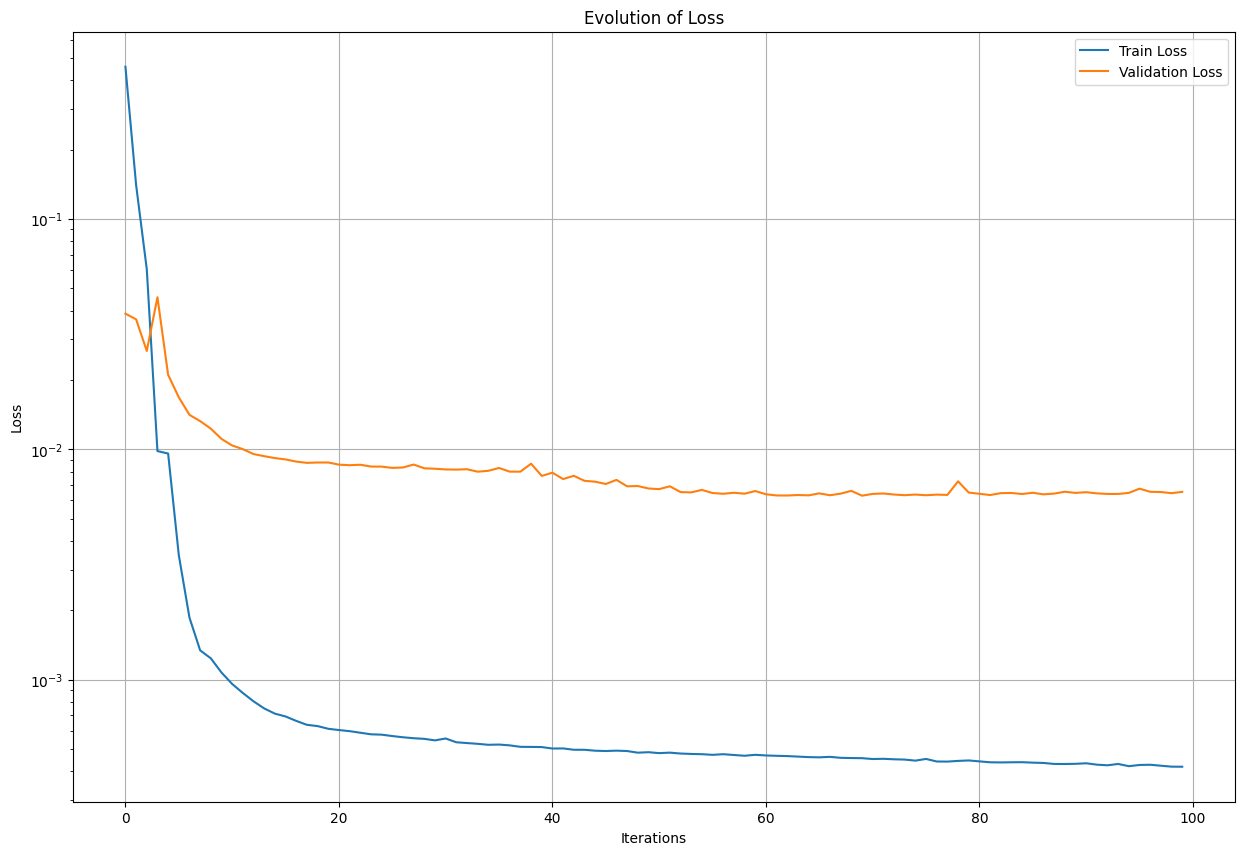

In [15]:
# Plot the training and validation losses
plot_train_val_loss(train_loss_values, val_loss_values)

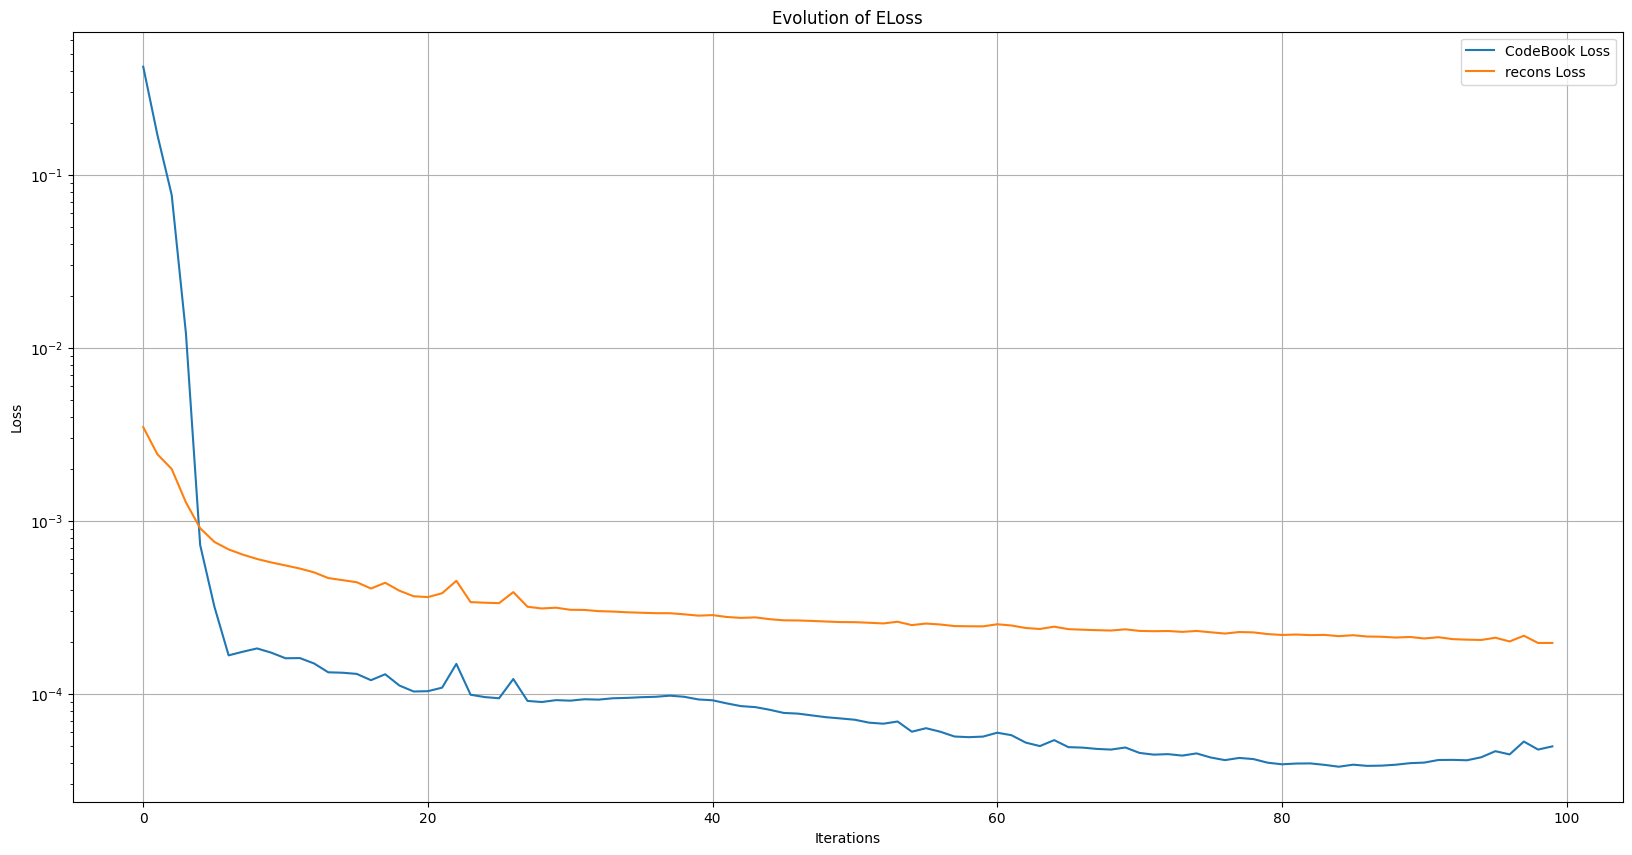

In [18]:


plot_rc_loss(train_loss_values, codebook_loss_values, beta=0.25)

# recons_loss_values = np.array(train_loss_values) - ( (1+0.25)*np.array(codebook_loss_values))
# # Plot the training and validation losses
# plt.figure(figsize=(30, 15))
# # plt.plot(train_loss_values, label='Train Loss')
# # plt.plot(val_loss_values, label='Validation Loss')
# plt.plot(codebook_loss_values, label = "CodeBook Loss")
# # plt.plot(commit_loss_values, label = "Committement Loss")
# plt.plot(recons_loss_values, label = "recons Loss")
# plt.xlabel('Iterations')
# plt.ylabel('Loss')
# plt.yscale('log')
# plt.title('Evolution of ELoss')
# plt.legend()
# plt.grid()
# plt.show()


# Test ...

In [ ]:
# visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

In [20]:
# batch_hat = reconstruct_logits(vis_batch, model)

# visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

In [ ]:
# visualize_batch_logits(recons_evolution[-1].detach().cpu(), title = "g")

#### VQVAE_MRI

In [16]:
def visualize_batch_MRI(batch):
    """ visualize a batch if the dataset is of type MRI and not SEG 
    works only if batch size > 16 """

    batch_size = batch.shape[0]
    if batch_size < 16 : 
        assert('code works only if batch_size bigger than 16')

    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # Adjust figsize to accommodate more rows
    fig.suptitle('Batch elements', fontsize=20)


    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(4):

        
        axes[i,0].imshow(batch[i].squeeze(0), cmap = 'gray')
        axes[i,1].imshow(batch[i+4].squeeze(0), cmap = 'gray')
        axes[i,2].imshow(batch[i+8].squeeze(0), cmap = 'gray')
        axes[i,3].imshow(batch[i+12].squeeze(0), cmap = 'gray')
        # axes[i].axis('off')

    
    plt.tight_layout()
    plt.show()

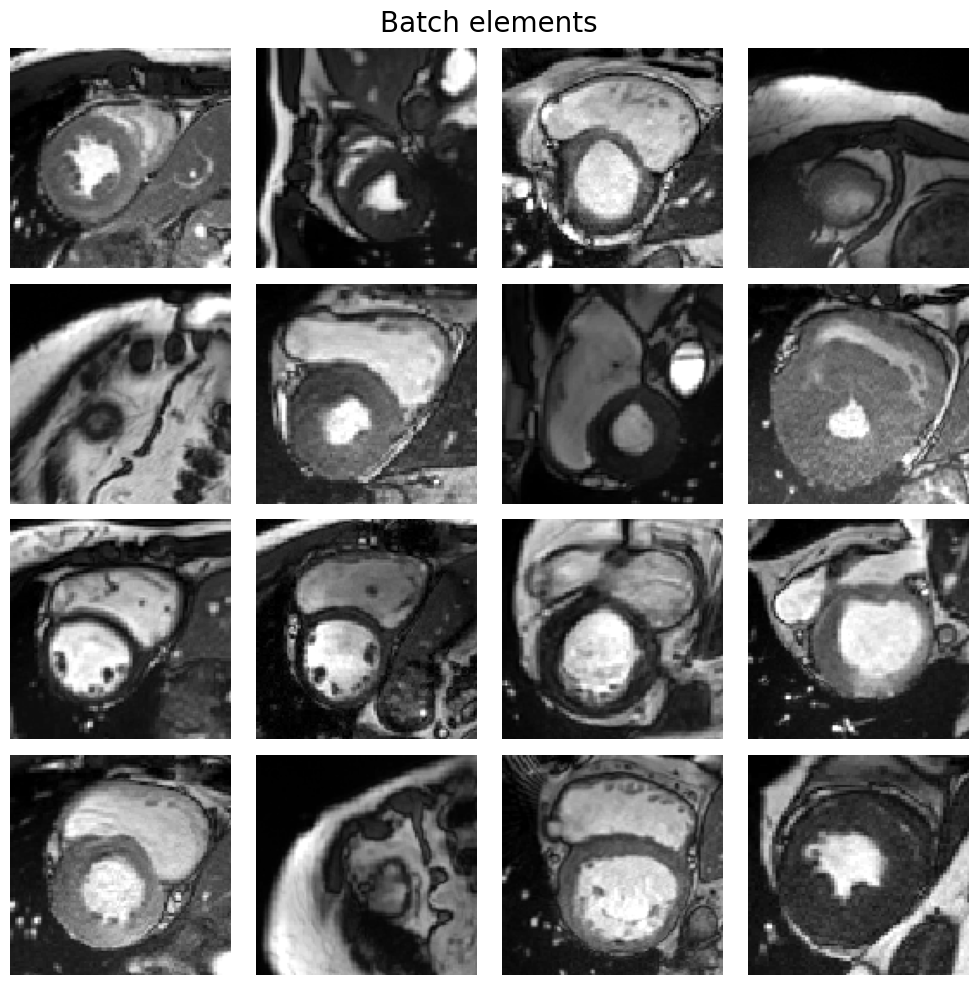

In [17]:
visualize_batch_MRI(vis_batch.cpu())

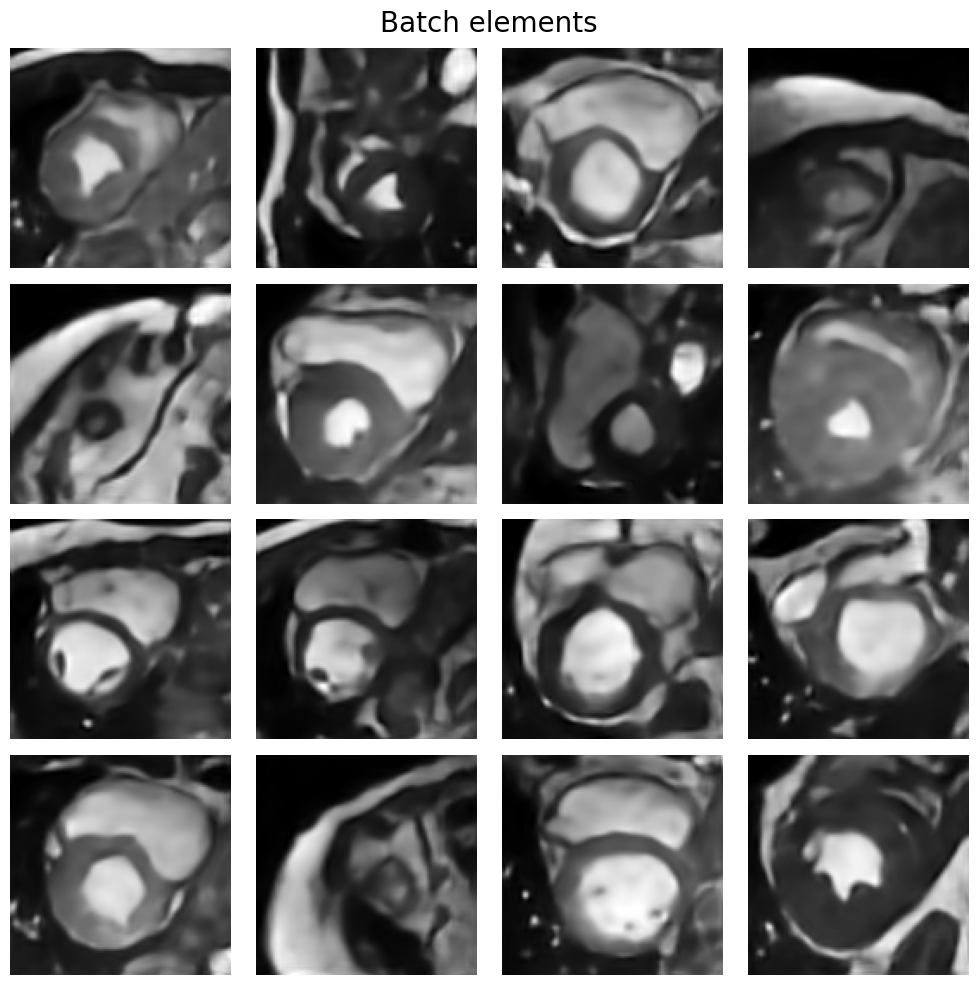

In [18]:
batch_hat, _, _, _ = model(vis_batch)
batch_hat = batch_hat.detach().cpu()
visualize_batch_MRI(batch_hat)